Installing all packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install yfinance
!pip install yahoofinancials
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import timedelta
from datetime import datetime
from scipy import stats
from yahoofinancials import YahooFinancials

Downloading data from 1.1. 2020 – 30.9.2023 YahooFinance. American stock is Microsoft 'MSFT' and fiat currency pair is EUR-JPY.

In [ ]:
df_total = yf.download(['BTC-USD', 'TSLA', 'NVDA', 'MSFT', 'EURJPY=X'],
                      start='2020-01-1',
                      end='2023-09-30',
                      progress=False).fillna(method='ffill')
df_total.head()
#df_total.Close.head() # Close prices

Adj Close                                             \
                BTC-USD    EURJPY=X        MSFT       NVDA    TSLA   
Date                                                                 
2020-01-01  7200.174316  121.970001         NaN        NaN     NaN   
2020-01-02  6985.470215  121.973000  154.779541  59.744045  28.684   
2020-01-03  7344.884277  121.245003  152.852264  58.787788  29.534   
2020-01-04  7410.656738  121.245003  152.852264  58.787788  29.534   
2020-01-05  7411.317383  121.245003  152.852264  58.787788  29.534   

                  Close                                             ...  \
                BTC-USD    EURJPY=X        MSFT       NVDA    TSLA  ...   
Date                                                                ...   
2020-01-01  7200.174316  121.970001         NaN        NaN     NaN  ...   
2020-01-02  6985.470215  121.973000  160.619995  59.977501  28.684  ...   
2020-01-03  7344.884277  121.245003  158.619995  59.017502  29.534  ...   
2020-01-04  7410.656738  121.245003  158.619995  59.017502  29.534  ...   
2020-01-05  7411.317383  121.245003  158.619995  59.017502  29.534  ...   

                   Open                                                \
                BTC-USD    EURJPY=X        MSFT       NVDA       TSLA   
Date                                                                    
2020-01-01  7194.892090  121.970001         NaN        NaN        NaN   
2020-01-02  7202.551270  121.969002  158.779999  59.687500  28.299999   
2020-01-03  6984.428711  121.239998  158.320007  58.775002  29.366667   
2020-01-04  7345.375488  121.239998  158.320007  58.775002  29.366667   
2020-01-05  7410.451660  121.239998  158.320007  58.775002  29.366667   

                 Volume                                                
                BTC-USD EURJPY=X        MSFT        NVDA         TSLA  
Date                                                                   
2020-01-01  18565664997      0.0         NaN         NaN          NaN  
2020-01-02  20802083465      0.0  22622100.0  23753600.0  142981500.0  
2020-01-03  28111481032      0.0  21116200.0  20538400.0  266677500.0  
2020-01-04  18444271275      0.0  21116200.0  20538400.0  266677500.0  
2020-01-05  19725074095      0.0  21116200.0  20538400.0  266677500.0  

[5 rows x 30 columns]

Downloading S&P500 data as a market representator

<Axes: title={'center': 'Market'}, xlabel='Date'>

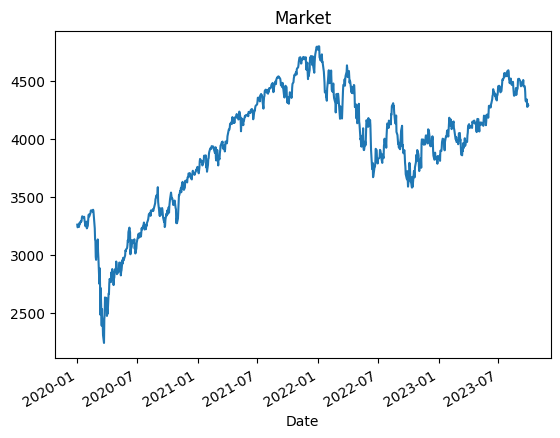

In [ ]:
SAP_df = yf.download('^GSPC',
                      start='2020-01-1',
                      end='2023-09-30',
                      progress=False).fillna(method='ffill')
SAP_df.head()
SAP_df['Close'].plot(title="Market")

Creating separate lists of returns for all stocks in order to calculate betas. Separate lists are created because lists will be of different length.

In [ ]:
BTC_adjclose = df_total['Adj Close']['BTC-USD'].dropna()
BTC_returns = BTC_adjclose.pct_change(1).dropna()                                   # Bitcoin returns
EURJPY_returns = df_total['Adj Close']['EURJPY=X'].dropna().pct_change(1).dropna()  # Fiat currency pair returns
MSFT_returns = df_total['Adj Close']['MSFT'].dropna().pct_change(1).dropna()        # MSFT returns
NVDA_returns = df_total['Adj Close']['NVDA'].dropna().pct_change(1).dropna()        # NVDA returns
TSLA_returns = df_total['Adj Close']['TSLA'].dropna().pct_change(1).dropna()        # TSLA returns
SAP_returns = SAP_df['Adj Close'].dropna().pct_change(1).dropna()                   # Market returns


Joining closing prices in order to calculate betas. NA values are filled with 0, because in days that stock was not traded it did not generate any return.

In [ ]:
daily_returns = pd.concat([BTC_returns, EURJPY_returns, MSFT_returns, NVDA_returns, TSLA_returns, SAP_returns], axis = 1).fillna(0)
daily_returns.columns = ['BTC', 'EURJPY', 'MSFT', 'NVDA', 'TSLA', 'SAP']
daily_returns.head()

#monthly_returns = daily_returns.asfreq('M')
#monthly_returns.head()

,BTC,EURJPY,MSFT,NVDA,TSLA,SAP
Date,,,,,,
2020-01-02,-0.029819,0.000025,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.051452,-0.005969,-0.012452,-0.016006,0.029633,-0.007060
2020-01-04,0.008955,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.048291,-0.006136,0.002585,0.004193,0.019255,0.003533


Calculating Betas with risk-free rate = 0 (as during the seminar).

In [ ]:
results = pd.DataFrame()
for col in daily_returns:
  y = daily_returns[col]
  X = daily_returns['SAP']
  X1 = sm.add_constant(X)
  model = sm.OLS(y, X1)
  par = model.fit().params
  results = pd.concat([results, par], axis = 1)
results.columns = daily_returns.columns
results.index = ['alpha', 'beta']
print(results.iloc[ :, 0:-1])


            BTC    EURJPY      MSFT     NVDA      TSLA
alpha  0.001317  0.000203  0.000344  0.00140  0.001825
beta   1.052648 -0.011906  1.179672  1.69028  1.508577


As we can see betas values vary for different assets. TSLA and NVDA betas are really high which means, that volatility of those stocks is much higher than volatility of the market, this fact makes those stocks more risky than others. It should be mentioned, that CAPM and MPT consider overall volatility as a measure of risk, which means, that those stocks could be rapidly growing, which will cause their betas to be high. Risk premium for those asset is high.

Interesting may be negative beta for currency pair EUR-JPY. Small value of beta means, that volatility of this pair is very low (which could be expected for two currencies). Negative value indicates that EUR/JPY will increase in price when market falls and vice versa. Risk premium in such case is negative (lower than risk free rate).

Beta coefficient of BTC/USD is only 1.05 which indicates that it generally follows market trend with a little bit of additional volatility. According to CAPM this is not very risky asset, but since beta is positive, risk premium is higher than risk-free rate.


**Creating lowest risk portfolio**

In order to find a minimum risk portfolio we will generate many portfolios and then choose the one with the lowest risk. (Risk in the MPT is defined as volatility)

When looking for optimal portfolios it is necessary to control correlations of different assets, since covariances of asset returns affect volatility of portfolio.

In [ ]:
daily_returns_assets = daily_returns.iloc[:, 0:5]
returns_annual = daily_returns_assets.mean()*250
cov_daily = daily_returns_assets.cov()
cov_annual = cov_daily*250
print(cov_annual)

             BTC    EURJPY      MSFT      NVDA      TSLA
BTC     0.314349  0.001230  0.052335  0.085116  0.088929
EURJPY  0.001230  0.005561 -0.001475 -0.001779 -0.000360
MSFT    0.052335 -0.001475  0.075692  0.092026  0.076013
NVDA    0.085116 -0.001779  0.092026  0.209772  0.138745
TSLA    0.088929 -0.000360  0.076013  0.138745  0.329459


In [ ]:
df_total['Adj Close'].corr().style.background_gradient(cmap='coolwarm').format(precision=2)

,BTC-USD,EURJPY=X,MSFT,NVDA,TSLA
BTC-USD,1.00,0.14,0.63,0.40,0.76
EURJPY=X,0.14,1.00,0.69,0.76,0.42
MSFT,0.63,0.69,1.00,0.90,0.80
NVDA,0.40,0.76,0.90,1.00,0.58
TSLA,0.76,0.42,0.80,0.58,1.00


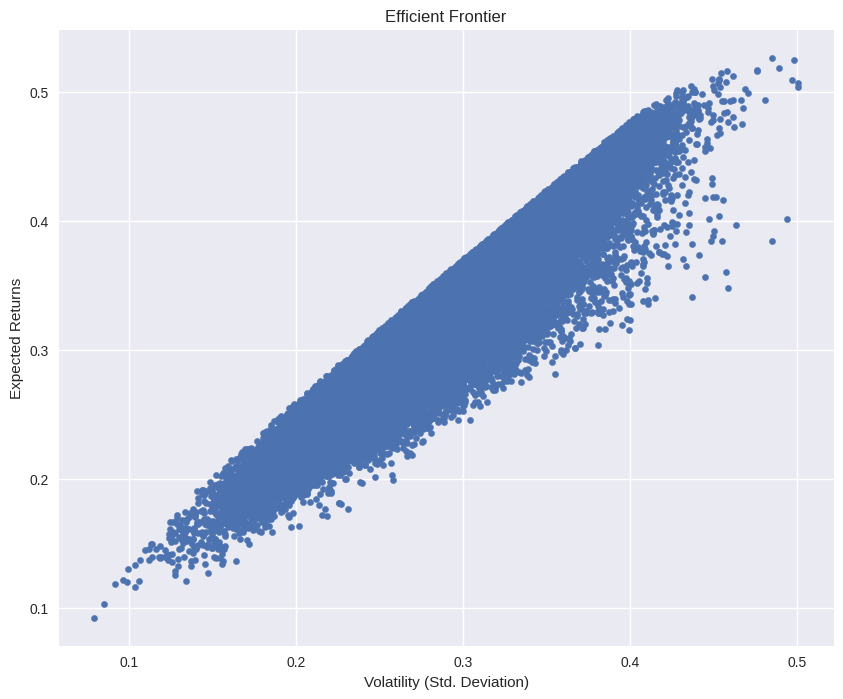

In [ ]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []

selected_tickers = returns_annual.index

# set the number of combinations for imaginary portfolios
num_assets = len(selected_tickers)
num_portfolios = 100000
np.random.seed(2303)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(cov_annual.columns):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected_tickers]

# reorder dataframe columns
df = df[column_order]

# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

100000 random portfolios were generated, in order to choose the lowest risk portfolio we will choose the portfolio with lowest volatility.

In [ ]:
min_vol_port = df.iloc[df['Volatility'].idxmin()]
min_vol_port

Returns          0.092247
Volatility       0.078830
BTC Weight       0.039174
EURJPY Weight    0.838520
MSFT Weight      0.080656
NVDA Weight      0.023184
TSLA Weight      0.018466
Name: 50053, dtype: float64

As we can see in portfolio with minimal volatility the greatest weight (0.83852) has our fiat currency pair EUR/JPY which originally had negative beta coefficient.
Had all assets been uncorrelated, our lowest risk portfolio would consisted only of this currency pair. But due to correlation the minimum risk is achieved when combining this currency pair with other assets.
The second high weight has MSFT. This weight could be explained by relatively (to other assets) low beta and negative correlation with EUR/JPY. Even though BTC/USD has lower beta (lower risk), it is poisitively correlated with EUR/JPY, which means causes additional portfolio volatility.
Total portfolio volatilit is 0.07883 and returns are 0.092. Returns are low, but those can be increased with choosing more risky portfolio. One of those 'more risky' portfolios could ba tangency portfolio which can be found by maximizing Sharpe ratio.

**Build the optimum risk portfolio given by the assets and the data, with risk free rate equal to 3.2 %.**

According to CAPM model, the optimum risk portfolio is the portfolio on the efficient frontier which maximizes Sharpe ratio.
Sharpe ratio can be calculated as follows:

$I_{Sharpe} = \frac{E_{r} - R_{f}}{σ} $,
where:
*   $E_{r}$ is expected portfolio return
*   $R_{f}$ is risk-free rate
*   $σ$ is the portfolio volatility



---
We will find this portfolio between our generated portfolios by looking for one that maximizes Sharpe ratio.



In [ ]:
rf = 0.032 # risk-free rate
optimal_risky_port = df.iloc[((df['Returns']-rf)/df['Volatility']).idxmax()]
optimal_risky_port

Returns          0.255128
Volatility       0.195845
BTC Weight       0.097150
EURJPY Weight    0.519227
MSFT Weight      0.005818
NVDA Weight      0.241941
TSLA Weight      0.135865
Name: 12846, dtype: float64

This is our portfolio optimal risk portfolio according to MPT. We can compare this portfolio with our minimum risk portfolio. Volatility is higher, but returns of the portfolio raised more than portfolio's volatility. This is because of Sharpe ratio maximization.

Still, our main asset is EUR/JPY, but its weight decreased by 30% and now is 0.5192. Much higher weight gained NVDA stock, which had high beta in the original CAPM model and is negatively correlated with EUR/JPY.

Fiat currency pair ensures lower risk of our portfolio, while main return comes from two stocks: NVDA (weight - 0.242) and TSLE (weight - 0.136). High stocks volatility means high risk premium and higher returns. Negative correlation between stocks and EUR/JPY gives us good total volatility of portfolio.


**Pick a VaR method of your choice and calculate the 99% 10 day VaR for the minimun risk and optimum risk portfolio. Comment the results.**

Our minimum risk and oprimal risk portfolios are:

In [ ]:
ports = pd.concat([min_vol_port, optimal_risky_port], axis = 1)
ports.columns = ['Minimal Risk', 'Optimal Risk']
print(ports)

               Minimal Risk  Optimal Risk
Returns            0.092247      0.255128
Volatility         0.078830      0.195845
BTC Weight         0.039174      0.097150
EURJPY Weight      0.838520      0.519227
MSFT Weight        0.080656      0.005818
NVDA Weight        0.023184      0.241941
TSLA Weight        0.018466      0.135865


We can calculate VaR either from empirical distribution, or from
approximation of our empirical distribution by some known distribution. Real world returns often do not follow any theoretical distriobution (they may be skewed or fat-tailed), so we can calculate VaR using our empirical distributions from data.



---

Define two functions to calculate VaR

In [ ]:
def getData(portfolio):
    df = pd.DataFrame()
    for stock in portfolio:
        s = yf.Ticker(stock)
        df[stock] = s.history(period='4y')["Close"]
    return df

def VaR(portfolio, weights, price, date = datetime.today()):
    '''
    Takes in the list of stocks in your portfolio,
    '''
    df = getData(portfolio)
    df = df[-501:]
    df_exp =(df)/df.iloc[0]
    df_exp = df_exp*weights*price
    df['Value'] = df_exp.sum(axis = 1)
    df_loss = df.set_index(np.arange(0,501,1))
    for i in range(1,501):
        df_loss.iloc[i-1] = (df.iloc[i]/df.iloc[i-1])*df.iloc[-1]
    df_loss = df_loss[:-1]
    for i in range (500):
        df_loss['Value'].iloc[i]  = round(df_loss["Value"].iloc[i]-df["Value"].iloc[-1] , 2)
    arr = df_loss['Value'].values *-1
    arr = np.sort(arr)
    print("The 10 day 99 percent confidence VaR is: ",'{:2f}'.format(round(arr[4],2)*math.sqrt(10)*-1))


Calculation of VaR using those functions

In [ ]:

portfolio = ['BTC-USD', 'TSLA', 'NVDA', 'MSFT', 'EURJPY=X']
weights = np.array(min_vol_port[2:8])
start = '2020-01-01'
price = 100
print('Minimal risk portfolio:')
VaR(portfolio, weights, price)
weights = np.array(optimal_risky_port[2:8])
print('Optimal risk portfolio:')
VaR(portfolio, weights, price)

Minimal risk portfolio:
The 10 day 99 percent confidence VaR is:  2.150349
Optimal risk portfolio:
The 10 day 99 percent confidence VaR is:  5.344249


For our minimal risk portfolio 10 day loss should not be greater than 2.15% of our portfolio. And for optimal risk portfolio 10 day loss should not exceed 5.34% of our portfolio cost. So if we would invested 1,000,000$ in our portfolios, then our 10 day loss would not be higher than 53508 in 99% cases for optimal risk portfolio and 21576 for minimal risk portfolio.

We can see that VaR for optimal risk portfolio is much higher than that of minimum risk portfolio, which should be expected, since our volatility grew much higher.

Generally, value at risk is a good measure of risk, which can be actively used when constructing or optimizing portfolios.